In [1]:
!pip install https://github.com/SPFlow/SPFlow/archive/refs/heads/master.zip

     - 81.6 MB 6.8 MB/s 0:00:19
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for setup: filename=setup-0.0.0-py3-none-any.whl size=259030 sha256=460e7b0662d418d8091a051710281cfade34390734bf16d6f24788e3fb72da77
  Stored in directory: /tmp/pip-ephem-wheel-cache-uomvvvny/wheels/e7/0b/48/dbb09177135d30baff79441681d9189c9f332ab47c537b9b3c
Successfully built setup


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##Load Data

In [4]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df = ratings_df.drop(columns=['timestamp'])
ratings_df.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
movie_encoder = LabelEncoder()
encoded_movie_ids = movie_encoder.fit_transform(ratings_df['userId'])

user_mapping = pd.DataFrame({
    'original_userId': ratings_df['userId'],
    'encoded_userId': encoded_movie_ids
})

print(user_mapping.drop_duplicates().head(10))


      original_userId  encoded_userId
0                   1               0
232                 2               1
261                 3               2
300                 4               3
516                 5               4
560                 6               5
874                 7               6
1026                8               7
1073                9               8
1119               10               9


In [6]:
ratings_df['userId'] = LabelEncoder().fit_transform(ratings_df['userId'])
ratings_df['movieId'] = LabelEncoder().fit_transform(ratings_df['movieId'])

# ratings_df['rating_class'] = (ratings_df['rating'] * 2).astype(int)

X = ratings_df[['userId', 'movieId']].values
y = ratings_df['rating'].values.reshape(-1, 1)
data = np.hstack((X, y))

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

##Train Model

In [7]:
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_classifier, learn_parametric
from spn.algorithms.MPE import mpe
import scipy

scipy.NINF = float("-inf")

ds_context = Context(parametric_types=[Categorical, Categorical, Gaussian])
ds_context.add_domains(train_data)

spn = learn_classifier(train_data, ds_context, learn_parametric, 2)

#Prediction
mpe_input = test_data.copy().astype(float)
mpe_input[:, 2] = np.nan
mpe_predictions = mpe(spn, mpe_input)

y_pred = mpe_predictions[:, 2]
y_true = test_data[:, 2]

/usr/local/lib/python3.11/dist-packages/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

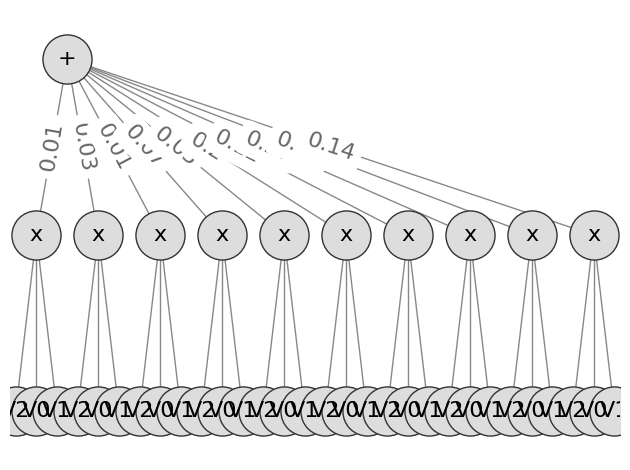

In [9]:
from spn.io.Graphics import draw_spn
draw_spn(spn)

In [10]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 1.3454
MAE: 0.9134
